This code perform feature reduction.

At the beginning of the code you can choose which original features you want to reduced. 
Every combinations of shape,firstorder (signal analysis) and texture feature that are already computed in the data folder.

If they are not run the pipeline_dataset.ipynb

This code first reduce the number of features by deleting features that have a too low variance.
Then we compute Correlation between feature, two different plots allows us to see which feature are correlate : 
The correlation matrix and the dendrogram scheme.

Then we use recursive feature extractor with a Random Forest to finish selecting the right amount of features we want.


In [485]:
import os 
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier         
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif


In [486]:
BASE_DIR = os.getcwd()

# look in the data folder and take the feature you want to reduced.
FEATURES_TO_ANALYSE = "shape_features"
# Shape + texture features 
DATA_DIR = os.path.join(BASE_DIR,"data",FEATURES_TO_ANALYSE)

TRAIN_DIR = os.path.join(DATA_DIR,"TrainningDataset.csv")
LABEL_DIR = os.path.join(DATA_DIR,"TrainningDatasetCategory.csv")
TEST_DIR = os.path.join(DATA_DIR,"TestingDataset.csv")


In [487]:
print(TRAIN_DIR)

/Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/data/shape_features/TrainningDataset.csv


In [488]:
X = pd.read_csv(TRAIN_DIR)  # contient "Id"
y = pd.read_csv(LABEL_DIR)  # contient "Id" et "Category"

# S'assurer que les ID sont bien des chaînes formatées
X["Id"] = X["Id"].astype(str).str.zfill(3)
y["Id"] = y["Id"].astype(str).str.zfill(3)

# Aligner y sur l’ordre de X
y = y.set_index("Id").loc[X["Id"]].reset_index()
y_train = y["Category"]


In [489]:
X_train = X.drop(columns=["Id"])


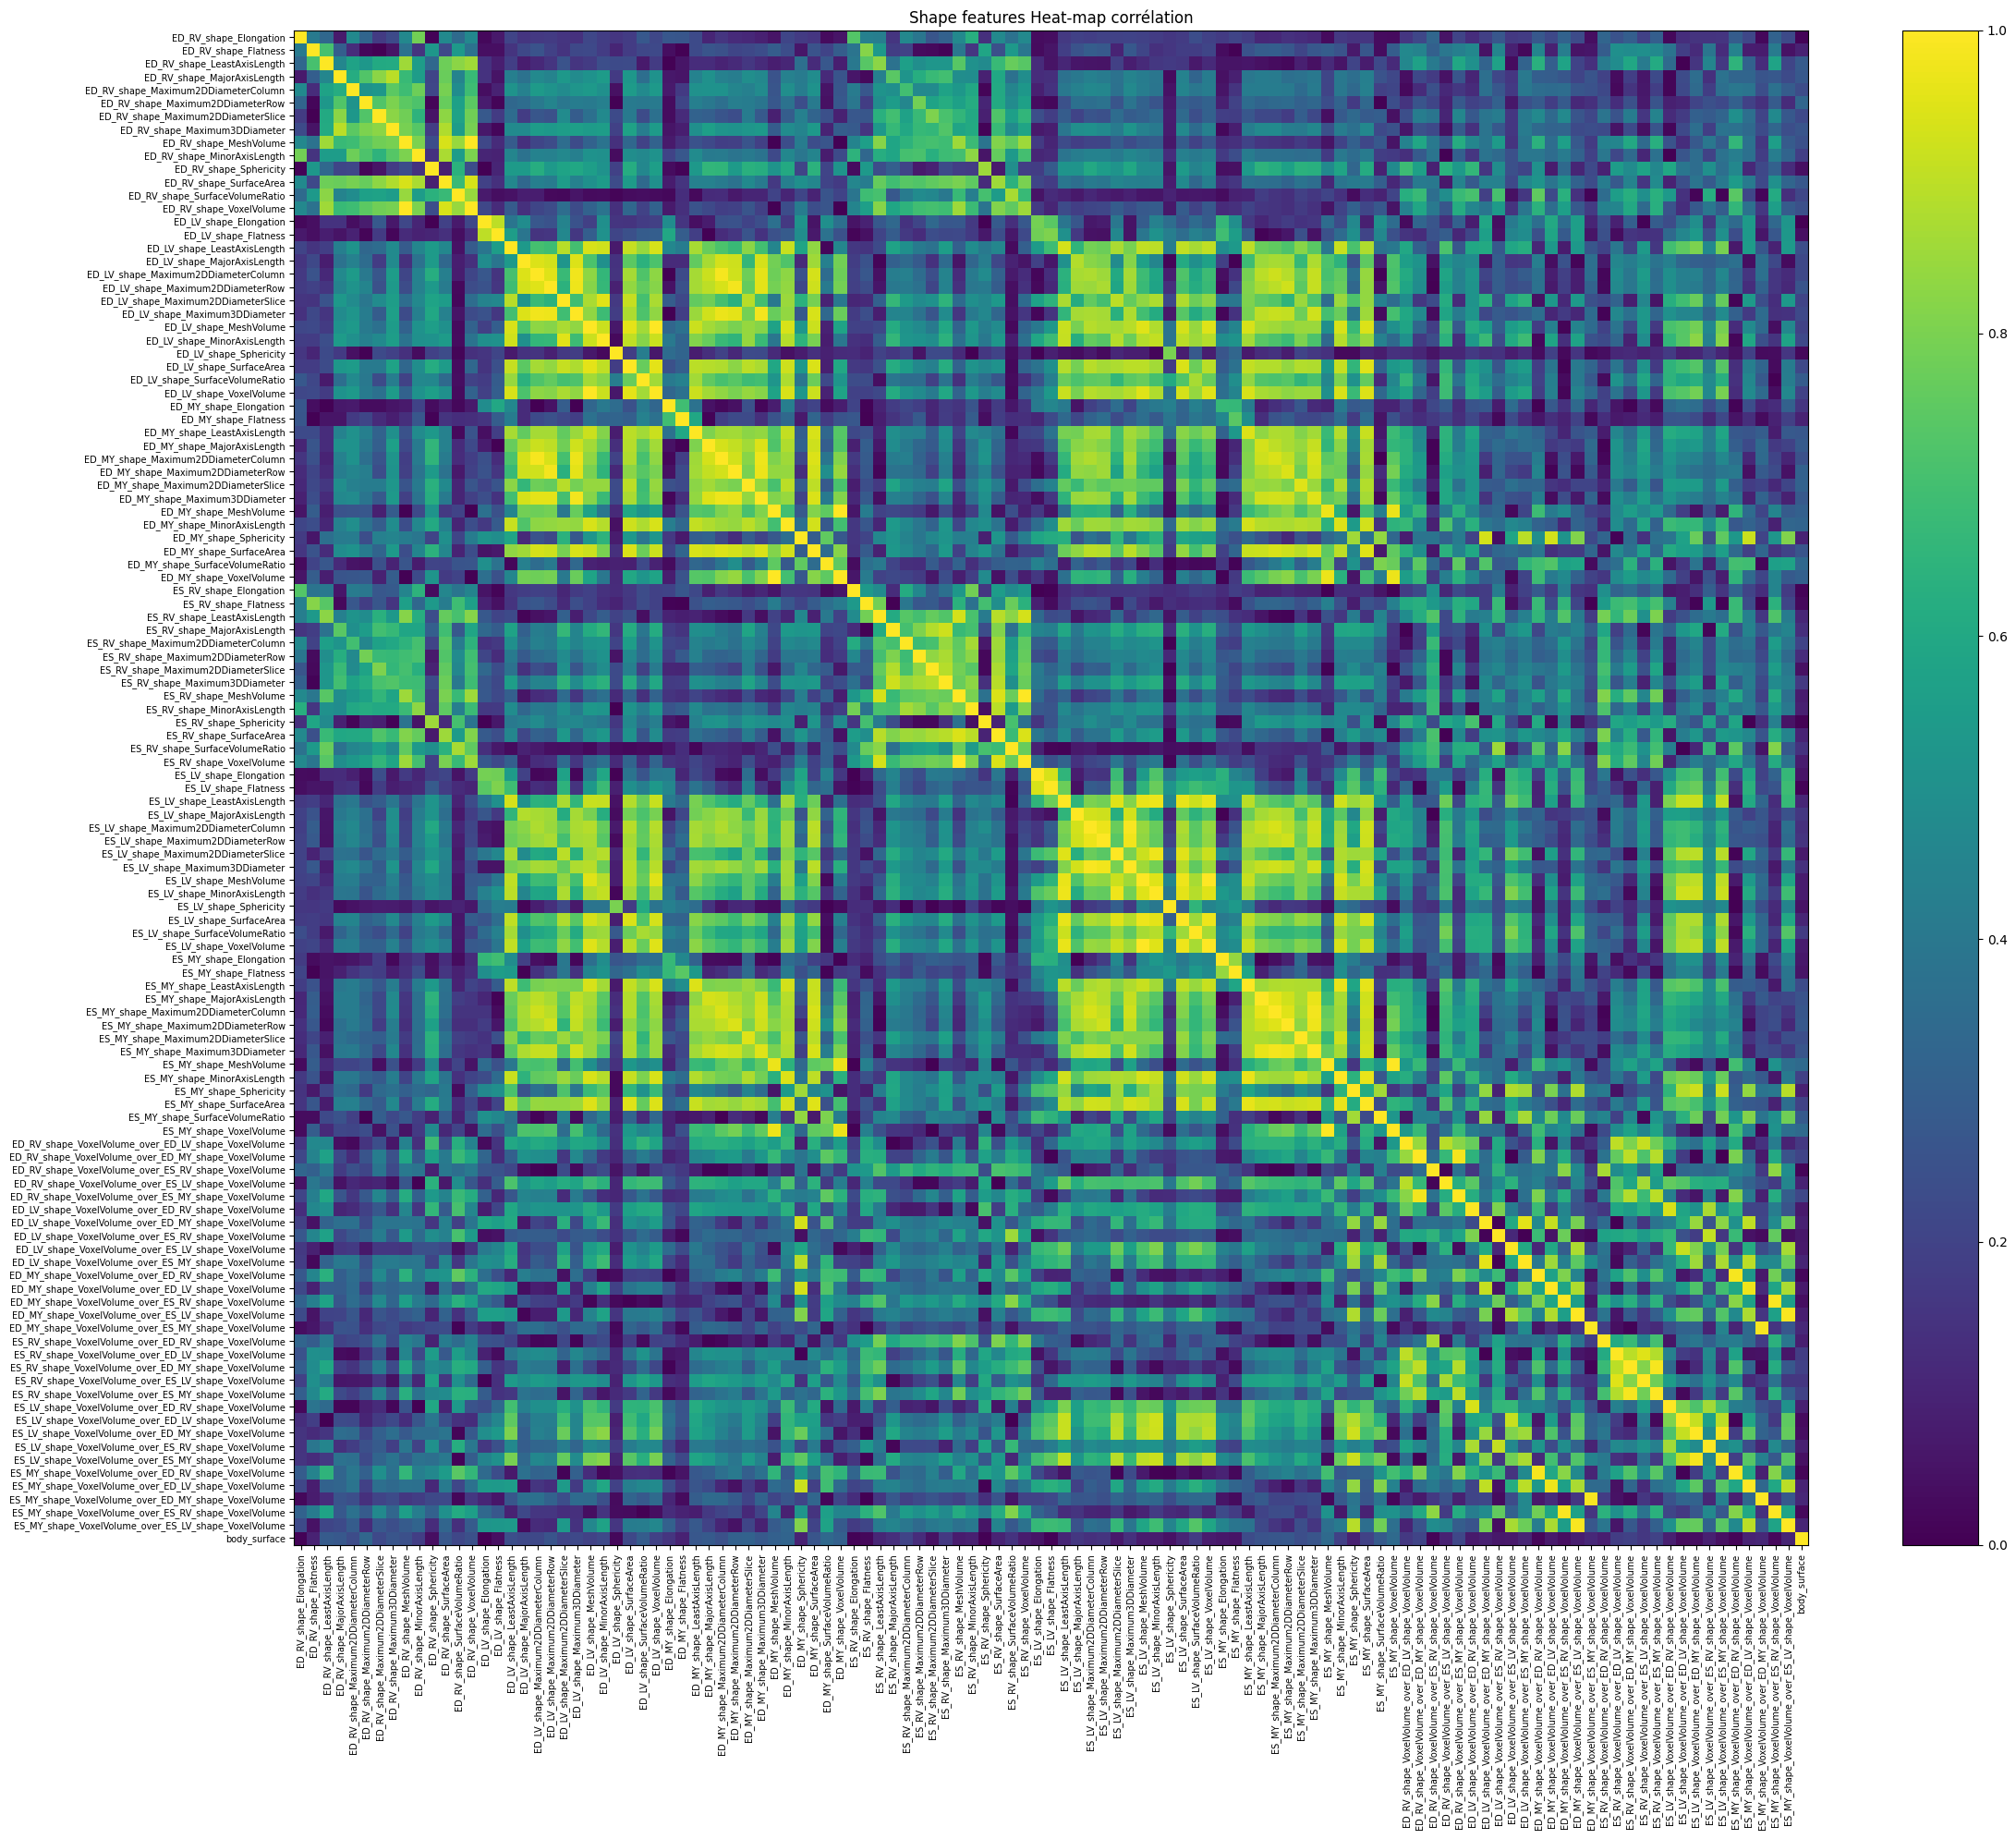

In [490]:
# Affichage de la Heat Map corrélation : on cherche à identifier les variables trop corrélés afin de les enlevés.
# En fonction du nombre de feature qu'on prend changer la figsize pour pouvoir voir.

scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)


corr = scaled_features.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(26, 20))
cax = ax.imshow(abs(corr), vmin=0, vmax=1, interpolation="nearest")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=7)
ax.set_yticklabels(corr.columns, fontsize=7)
fig.colorbar(cax, fraction=0.046, pad=0.04)
plt.title("Shape features Heat-map corrélation")
plt.tight_layout()
#fig.savefig("heatmap_corr_glrlm_f.png", dpi=300, transparent=True, bbox_inches="tight")

plt.show()

/var/folders/cs/66ymsgmj2cl8m73sky0c22xw0000gn/T/ipykernel_5533/2162856499.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(1 - corr, method='average')


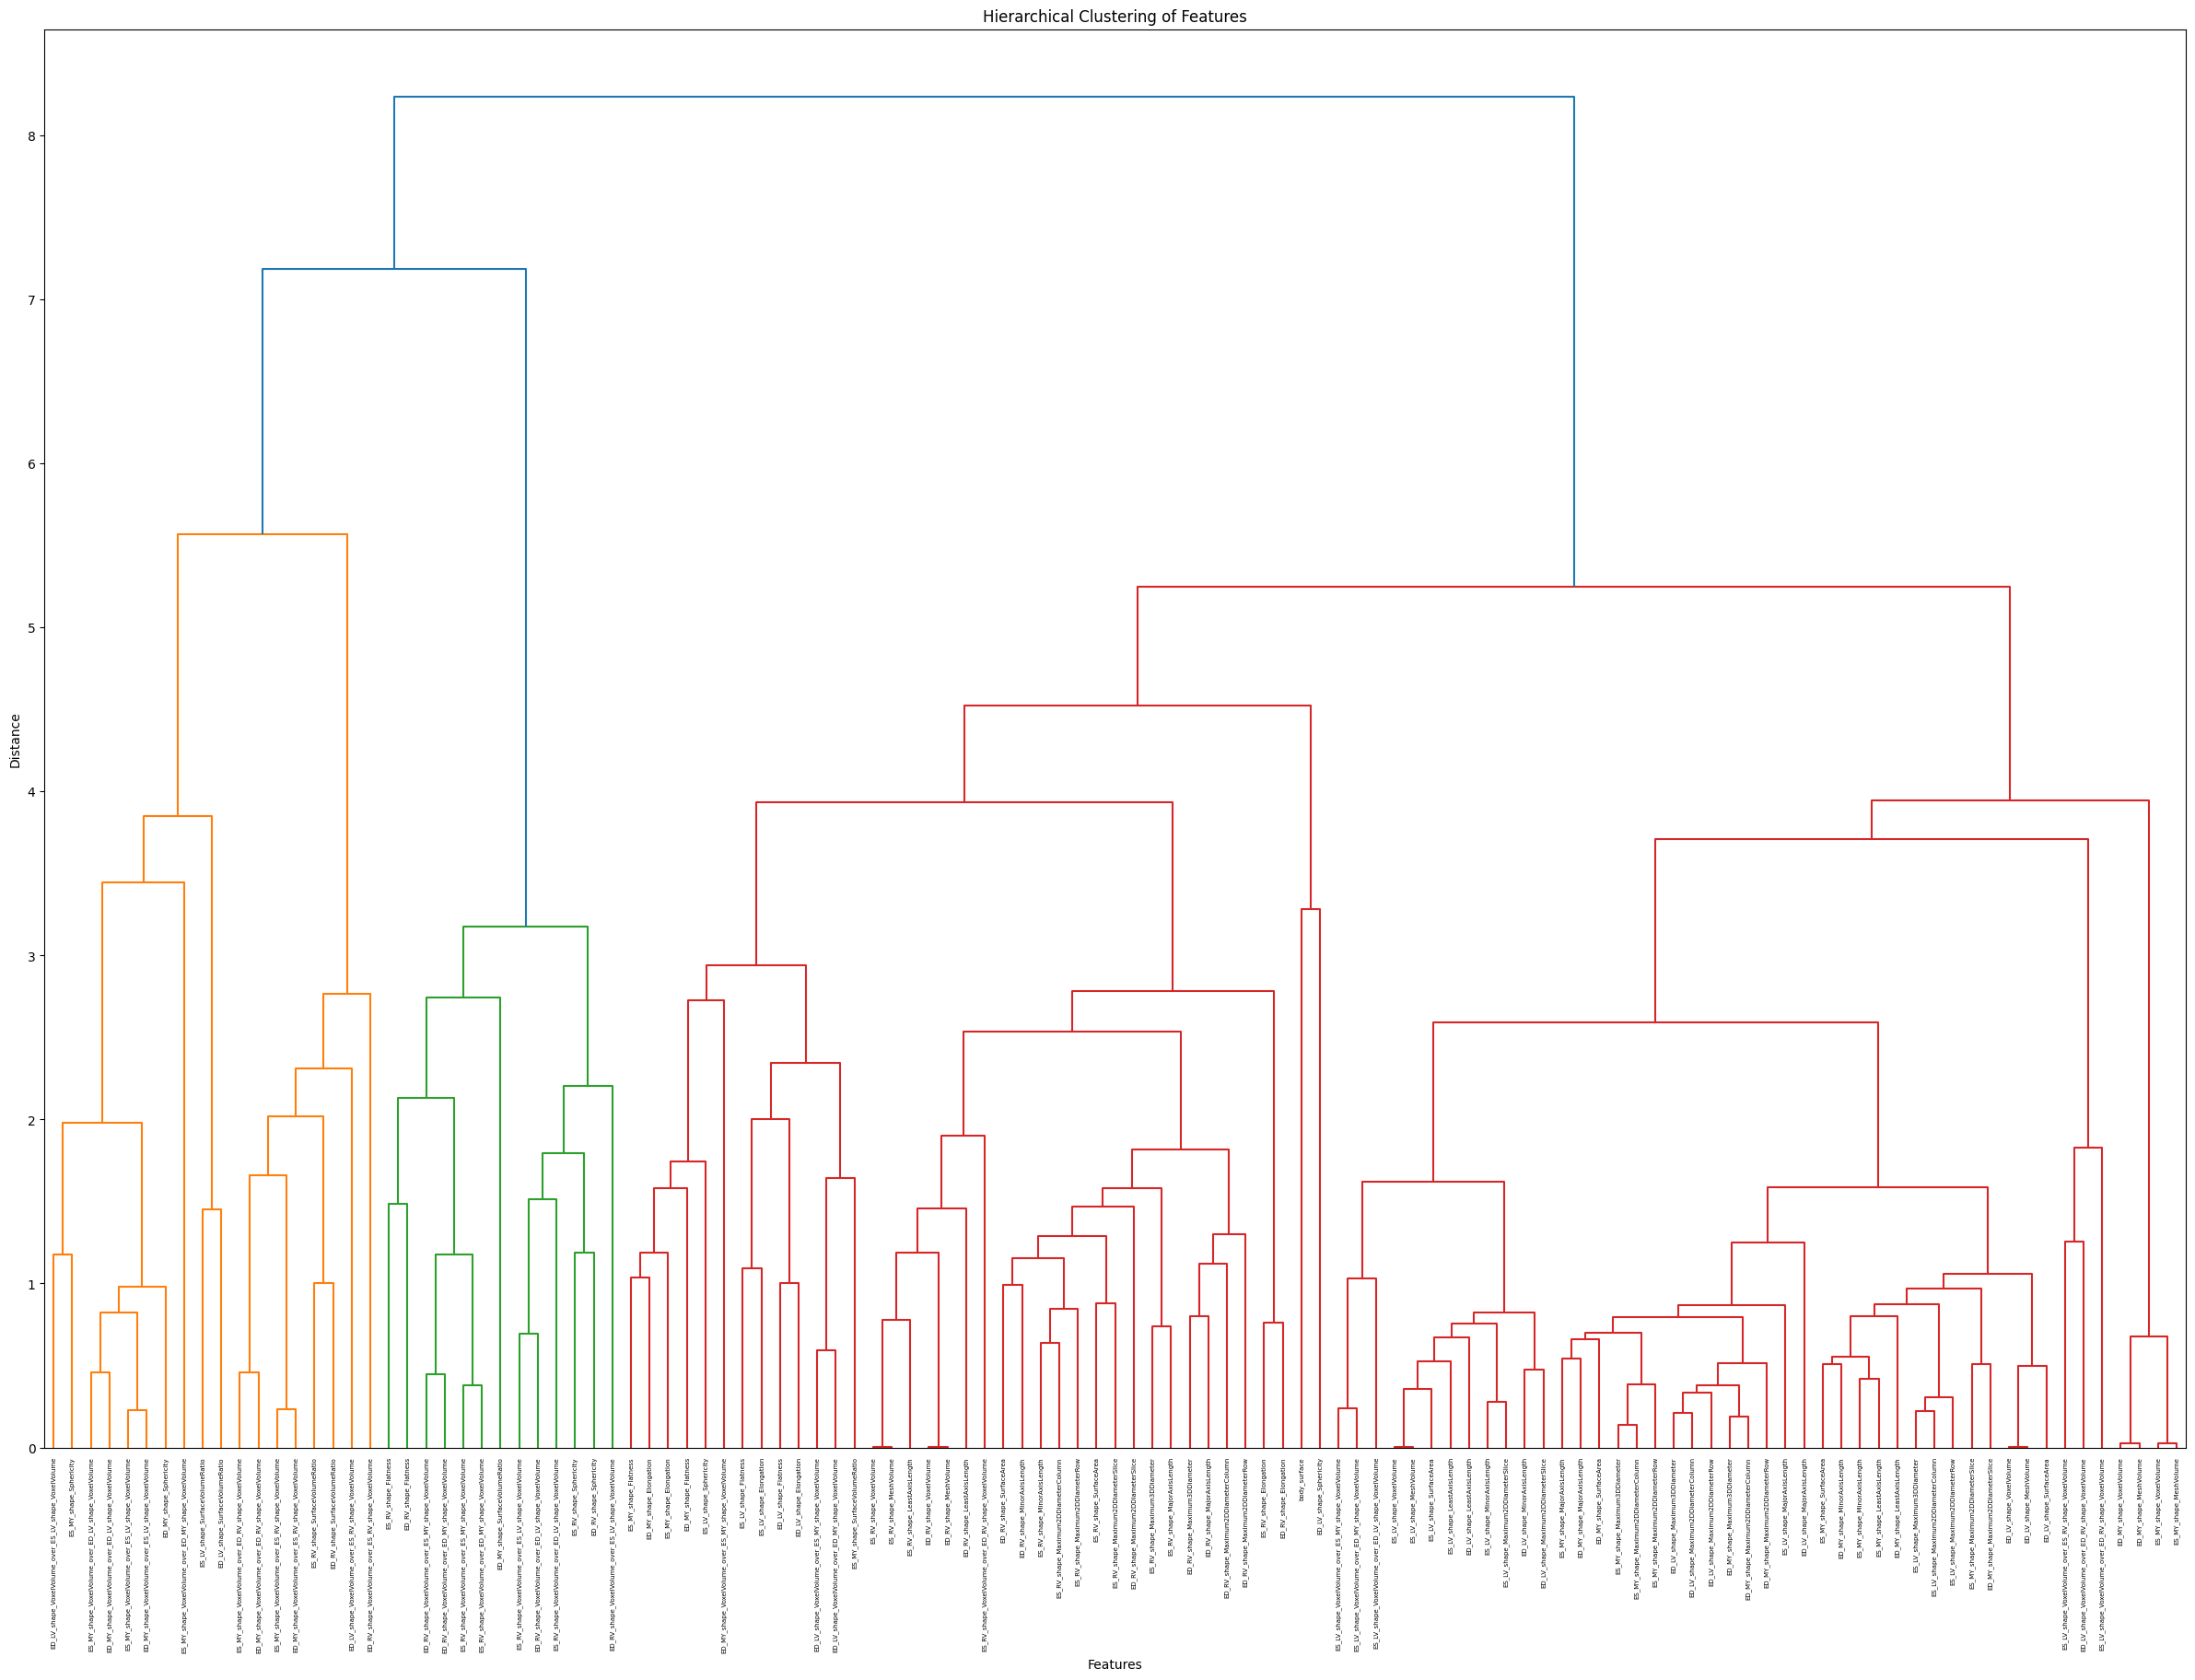

In [491]:
linkage_matrix = sch.linkage(1 - corr, method='average')


# We plot what is called a dendrogram to vizualize relationship between the different features.
plt.figure(figsize=(30, 20))
sch.dendrogram(linkage_matrix, labels=scaled_features.columns, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title("Hierarchical Clustering of Features")
plt.xlabel("Features")
plt.ylabel("Distance")
plt.show()

In [492]:
# On retire les features avec une Variance trop faible. Pour l'instant je supprime juste les features constantes.

var_sel = VarianceThreshold(threshold=1e-3)     
X1 = var_sel.fit_transform(X_train)
selected_var = X_train.columns[var_sel.get_support()]
print(f"Number of features removed bc of too small variance : {len(X_train.columns) - len(selected_var)}")


Number of features removed bc of too small variance : 2


In [493]:
T = 0.92
def drop_high_corr(df, threshold=0.9):
    c = df.corr(numeric_only=True).abs()
    upper = c.where(np.triu(np.ones(c.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return df.drop(columns=to_drop), to_drop

X2_df, highly_corr = drop_high_corr(pd.DataFrame(X1, columns=selected_var), threshold=T)

print(f"Features retirées pour avec critère de corrélation > {T} : {len(highly_corr)}")
print(f"Nombre de features restantes : {X2_df.shape[1]}")


Features retirées pour avec critère de corrélation > 0.92 : 56
Nombre de features restantes : 57


In [494]:
import sklearn_mrmr.mrmr

mrmr_sel = sklearn_mrmr.mrmr.MRMRFeatureSelector(n_features_to_select=40)
selected_final = list(mrmr_sel.fit_transform(X2_df, y_train).columns)


In [481]:

# Séparer les features par famille
shape_feats = [col for col in X2_df.columns if "shape" in col]
first_feats = [col for col in X2_df.columns if "firstorder" in col]
glcm_feats  = [col for col in X2_df.columns if "glcm" in col]
glrlm_feats = [col for col in X2_df.columns if "glrlm" in col] 

N_shape = 15
N_first = 0
N_glrlm = 0
N_glcm =  0

def select_kbest(X, y, columns, k):
    if not columns or k == 0:
        return []
    k = min(k, len(columns)) 
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X[columns], y)
    return list(np.array(columns)[selector.get_support()])


selected_shape = select_kbest(X2_df, y_train, shape_feats, N_shape)
selected_first = select_kbest(X2_df, y_train, first_feats, N_first)
selected_glcm  = select_kbest(X2_df, y_train, glcm_feats, N_glcm)
selected_glrlm = select_kbest(X2_df, y_train, glrlm_feats, N_glrlm) 

selected_final = selected_shape + selected_first + selected_glcm + selected_glrlm
print("Features retenues  :", selected_final)


Features retenues  : [np.str_('ED_LV_shape_LeastAxisLength'), np.str_('ED_MY_shape_MeshVolume'), np.str_('ED_MY_shape_Sphericity'), np.str_('ES_LV_shape_SurfaceVolumeRatio'), np.str_('ES_MY_shape_Sphericity'), np.str_('ES_MY_shape_SurfaceVolumeRatio'), np.str_('ED_RV_shape_VoxelVolume_over_ED_LV_shape_VoxelVolume'), np.str_('ED_RV_shape_VoxelVolume_over_ED_MY_shape_VoxelVolume'), np.str_('ED_RV_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume'), np.str_('ED_LV_shape_VoxelVolume_over_ED_RV_shape_VoxelVolume'), np.str_('ED_LV_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume'), np.str_('ED_MY_shape_VoxelVolume_over_ED_RV_shape_VoxelVolume'), np.str_('ED_MY_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume'), np.str_('ES_RV_shape_VoxelVolume_over_ED_LV_shape_VoxelVolume'), np.str_('ES_RV_shape_VoxelVolume_over_ED_MY_shape_VoxelVolume')]


In [254]:
selected_final = X2_df.columns.to_list()


['ED_RV_shape_Elongation', 'ED_RV_shape_Flatness', 'ED_RV_shape_LeastAxisLength', 'ED_RV_shape_MajorAxisLength', 'ED_RV_shape_Maximum2DDiameterColumn', 'ED_RV_shape_Maximum2DDiameterRow', 'ED_RV_shape_Maximum2DDiameterSlice', 'ED_RV_shape_Maximum3DDiameter', 'ED_RV_shape_MeshVolume', 'ED_RV_shape_MinorAxisLength', 'ED_RV_shape_Sphericity', 'ED_LV_shape_Elongation', 'ED_LV_shape_Flatness', 'ED_LV_shape_LeastAxisLength', 'ED_LV_shape_MajorAxisLength', 'ED_LV_shape_Maximum2DDiameterSlice', 'ED_LV_shape_Sphericity', 'ED_MY_shape_Elongation', 'ED_MY_shape_Flatness', 'ED_MY_shape_Maximum2DDiameterSlice', 'ED_MY_shape_MeshVolume', 'ED_MY_shape_Sphericity', 'ED_MY_shape_SurfaceVolumeRatio', 'ES_RV_shape_Elongation', 'ES_RV_shape_Flatness', 'ES_RV_shape_LeastAxisLength', 'ES_RV_shape_MajorAxisLength', 'ES_RV_shape_Maximum2DDiameterColumn', 'ES_RV_shape_Maximum2DDiameterRow', 'ES_RV_shape_Maximum2DDiameterSlice', 'ES_RV_shape_MinorAxisLength', 'ES_RV_shape_Sphericity', 'ES_RV_shape_SurfaceVolume

In [418]:
print(selected_final)

['ES_RV_shape_VoxelVolume_over_ED_LV_shape_VoxelVolume', 'ES_RV_shape_VoxelVolume_over_ED_MY_shape_VoxelVolume', 'ES_LV_glcm_Correlation', 'ED_RV_shape_VoxelVolume_over_ED_LV_shape_VoxelVolume', 'ED_RV_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume', 'ES_MY_glcm_Correlation', 'ES_LV_shape_Sphericity', 'ED_RV_shape_VoxelVolume_over_ED_MY_shape_VoxelVolume', 'ES_LV_shape_SurfaceVolumeRatio', 'ES_RV_shape_Maximum2DDiameterSlice', 'ES_RV_shape_VoxelVolume_over_ED_RV_shape_VoxelVolume', 'ED_LV_shape_Sphericity', 'ES_RV_firstorder_Energy', 'ES_MY_glcm_Imc1', 'ES_RV_glrlm_GrayLevelNonUniformity', 'ES_RV_shape_LeastAxisLength', 'ES_LV_glcm_Contrast', 'ED_MY_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume', 'ES_RV_shape_Maximum2DDiameterRow', 'ES_LV_shape_VoxelVolume_over_ES_RV_shape_VoxelVolume', 'ED_LV_glcm_Contrast', 'ED_LV_shape_VoxelVolume_over_ED_RV_shape_VoxelVolume', 'ED_LV_shape_VoxelVolume_over_ES_RV_shape_VoxelVolume', 'ES_LV_glcm_Id', 'ED_RV_shape_Maximum2DDiameterSlice', 'ES_RV_shap

In [495]:

pd.Series(selected_final).to_csv(os.path.join(DATA_DIR, "SelectedFeatures.csv"), index=False, header=["Feature"])

X_train_reduced = X[["Id"] + selected_final]


X_train_reduced.to_csv(os.path.join(DATA_DIR, "TrainningDataset_reduced.csv"), index=False)



In [496]:
# use the same feature for the test set. 
# Ensure that the test set uses the same 'Id' as the training set

X_test = pd.read_csv(os.path.join(DATA_DIR,"TestingDataset.csv"))
X_test_reduced = pd.DataFrame(X_test,columns=X_train_reduced.columns)
X_test_reduced.to_csv(os.path.join(DATA_DIR, "TestingDataset_reduced.csv"), index=False)


In [497]:
rf   = RandomForestClassifier(n_estimators=100 ,n_jobs=-1)

pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", rf)
])
cv = StratifiedKFold(n_splits=5, shuffle=True)
scores = cross_val_score(pipe,X_train_reduced.drop(columns=["Id"]),y_train.squeeze(),cv=cv, scoring="accuracy")

print("mean accuracy :", scores.mean(), "±", scores.std())



mean accuracy : 0.9400000000000001 ± 0.058309518948453015
